# visual run

In [1]:
import os
import time
import argparse
import logging
import numpy as np
# np.set_printoptions(precision=3, suppress=True)
import matplotlib.pyplot as plt

import torch.nn as nn

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from skimage import io
from skimage.transform import rescale, resize, downscale_local_mean
from ifcn import unet
import json
import matplotlib.pyplot as plt

from PIL import Image
from dataset import SegmentationDataset
from metrics import dice_loss, dice_score, seg_loss

In [2]:
logging.basicConfig(filename='output.log', filemode='w',
                    format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO,
                    datefmt="%Y-%m-%d %H:%M:%S"
)

In [3]:
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight.data)
        if m.bias is not None:
            m.bias.data.zero_()

In [4]:
def main():
    ######################## Hyperparameters #################################
    train_batch_size = 10  # orig 10, 5 for large original image size
    validation_batch_size = 5  # orig 10
    learning_rate = 0.001
    num_classes = 26

    # SET EPOCH (STAR)
    num_epochs = 20

    # Data Directory
    input_data_dir = mask_json = r'data'

    # Mask Json directory
    mask_json = r'data/mapping.json'

    # Image Transforms
    train_transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    img_transform = transforms.Compose([
        transforms.ToTensor(),
    ])

    # Instantiate DataSets
    train_dataset = SegmentationDataset(input_data_dir, 'train', mask_json, transforms=train_transform)
    val_dataset   = SegmentationDataset(input_data_dir, 'val', mask_json, transforms=img_transform)
    test_dataset  = SegmentationDataset(input_data_dir, 'test', mask_json, transforms=img_transform)

    # Instantiate dataloaders
    train_dataloader = DataLoader(train_dataset, batch_size=train_batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=validation_batch_size, shuffle=True)
    test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

    # gpu or cpu
    print(torch.cuda.get_device_name(0))
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Initializations
    model = unet(num_classes=num_classes, useBN=True)
    model = model.to(device)
    weights_init(model)
    loss_fn = dice_loss()

    # other loss function options:
    # loss_fn = GeneralizedDiceLoss()
    # loss_fn = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    ############################ INITIALIZE ############################
    torch.cuda.empty_cache()

    displayBatch =  False
    displayEpoch =  True
    epoch_train_loss = []
    epoch_train_accuracy_per_class = []
    epoch_train_accuracy_average = []

    epoch_val_loss = []
    epoch_val_accuracy_per_class = []
    epoch_val_accuracy_average = []

    for epic in range(num_epochs):
        print('starting epoch:', epic)
        
        # Put model in training mode
        model.train()
        correct = 0  # for class identification
        
        train_total = 0
        train_batch_loss = 0
        train_batch_accuracy = np.empty((0, num_classes))
        
        for i, sample in enumerate(train_dataloader):
            img_patch = sample['img']  # x
            ins_patch = sample['ins']  # x part 2
            gt_patch = sample['gt']  # y, ground truth
            weight = sample['weight']
            c_label = sample['c_label']  # torch.Size([10]), tensor([1., 0., ...])

            # concatenate IFCN train patch: image and instance memory
            input_patch = torch.cat((img_patch, ins_patch), dim=1)
            
            # move inputs to device
            if torch.cuda.is_available():
                input_patch = input_patch.to(device)
                gt_patch = gt_patch.to(device)
                weight = weight.to(device)
                c_label = c_label.to(device)
            
            # Loop over model
            optimizer.zero_grad()
            # output = model.forward(x)  # N K H W
            S, C = model.forward(input_patch.float())  # C is size [10, 1], squeeze?

            # calculate dice coefficient
            train_dice_coeff = dice_score(S, gt_patch)

            # calculate dice per-class loss - use IFCN train loss instead
            # loss = loss_fn(S, gt_patch)
            # loss.backward()

            # calculate total loss (with weight and completeness classification)
            loss_lambda = 0.1  # avoid using lambda as variable name
            FP, FN = seg_loss(S, gt_patch, weight)
            s_loss = loss_lambda * FP + FN
            c_loss = F.binary_cross_entropy(torch.squeeze(C), c_label)
            train_loss = s_loss + c_loss

            logging.info("train_dice_coeff: %s, S Loss: %s, C Loss: %s" % (train_dice_coeff, s_loss.item(), c_loss.item()))

            # ignore this for now
#             C_one_hot = torch.flatten(C.round())  # torch.Size([10, 1])
#             print('C flatten shape is:',np.shape(C.round()))  # no change
#             print('C flatten type is:',type(C.round()))
#             print('C flatten is:',C.round())
#             if C_one_hot == c_label:
#                 correct = 1

            train_loss.backward()
            optimizer.step()
            
            # Dice score for training
            train_batch_accuracy = np.vstack((train_batch_accuracy, train_dice_coeff))
            
            # make transition a little easier by just renaming variables for this section
            output = S
            y = gt_patch
            x = input_patch
            loss = train_loss
            
            # Display
            if displayBatch is True:
                _, y_hat = torch.max(output, dim=1) # argmax over classes
                _, y_flat = torch.max(y.detach().clone(), dim=1)
                disp_mask = y_flat.cpu().numpy()
                disp_y_hat = y_hat.cpu().numpy()
                plt.figure(figsize=(12,8))
                plt.subplot(1,2,1)
                plt.imshow(disp_mask[0])
                plt.title("Target")
                plt.subplot(1,2,2)
                plt.imshow(disp_y_hat[0])
                plt.title("Predicted")
                plt.show()
            
            # Since loss is averaged over class and batch, to get total loss we need to multiply by NK
            N, K, H, W = x.shape
            train_total += N*K
            train_batch_loss += loss.item() * N * K

        if displayEpoch is True:
            _, y_hat = torch.max(output, dim=1) # argmax over classes
            _, y_flat = torch.max(y.detach().clone(), dim=1)
            disp_mask = y_flat.cpu().numpy()
            disp_y_hat = y_hat.cpu().numpy()
            plt.figure(figsize=(12,8))
            plt.subplot(1,2,1)
            plt.imshow(disp_mask[0])
            plt.title("Target")
            plt.subplot(1,2,2)
            plt.imshow(disp_y_hat[0])
            plt.title("Predicted")
            plt.show()
            
        # Append to epoch loss/accuracy
        epoch_train_loss.append(train_batch_loss / train_total)
        a = train_batch_accuracy.mean(axis=0)
        epoch_train_accuracy_per_class.append(a) # mean over class to get per class accuracy
        epoch_train_accuracy_average.append(train_batch_accuracy.mean())
        
        print('='*50 + " Training " + '='*50)
        print(f'Epoch: {epic}, Train Loss: {epoch_train_loss[-1]}, Average Dice Score: {epoch_train_accuracy_average[-1]}')
        print('Dice Score Per Class')
        print('0: {0:.2f} 1: {1:.2f} 2: {2:.2f} 3: {3:.2f} 4: {4:.2f} 5: {5:.2f} 6: {6:.2f} 7: {7:.2f} 8: {8:.2f} 9: {9:.2f} 10: {10:.2f} 11: {11:.2f} 12: {12:.2f} 13: {13:.2f} 14: {14:.2f} 15: {15:.2f} 16: {16:.2f} 17: {17:.2f} 18: {18:.2f} 19: {19:.2f} 20: {20:.2f} 21: {21:.2f} 22: {22:.2f} 23: {23:.2f} 24: {24:.2f} 25: {25:.2f}'.format(a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9], a[10], a[11], a[12], a[13], a[14], a[15], a[16], a[17], a[18], a[19], a[20], a[21], a[22], a[23], a[24], a[25]))
        
        # Put model in validation mode
        model.eval()

        val_total = 0
        val_batch_loss = 0
        val_batch_accuracy = np.empty((0, num_classes))
            
        with torch.no_grad():
            for i, sample in enumerate(val_dataloader):
                img_patch = sample['img']  # x
                ins_patch = sample['ins']  # x part 2
                gt_patch = sample['gt']  # y, ground truth
                weight = sample['weight']
                c_label = sample['c_label']
                
                # concatenate IFCN train patch: image and instance memory
                input_patch = torch.cat((img_patch, ins_patch), dim=1)

                # move inputs to device
                if torch.cuda.is_available():
                    input_patch = input_patch.to(device)
                    gt_patch = gt_patch.to(device)
                    weight = weight.to(device)
                    c_label = c_label.to(device)
                
                S, C = model.forward(input_patch.float())
                
                # calculate total loss (with weight and completeness classification)
                loss_lambda = 0.1  # avoid using lambda as variable name
                FP, FN = seg_loss(S, gt_patch, weight)
                s_loss = loss_lambda * FP + FN
                c_loss = F.binary_cross_entropy(torch.squeeze(C), c_label)
                train_loss = s_loss + c_loss
                
                # calculate dice coefficient
                train_dice_coeff = dice_score(S, gt_patch)
                
                # Dice score for training
                val_batch_accuracy = np.vstack((val_batch_accuracy, train_dice_coeff))
                
                # make transition easier, as before
                output = S
                y = gt_patch
                x = input_patch
                loss = train_loss
                
                # Since loss is averaged over class and batch, to get total loss we need to multiply by NK
                N, K, H, W = x.shape
                val_total += N*K
                val_batch_loss += train_loss.item() * N * K
                
            # Append to epoch loss/accuracy
            epoch_val_loss.append(val_batch_loss / val_total)
            b = val_batch_accuracy.mean(axis=0)
            epoch_val_accuracy_per_class.append(a) # mean over class to get per class accuracy
            epoch_val_accuracy_average.append(val_batch_accuracy.mean())
            
            print('='*49 + " Validation " + '='*49)
            print(f'Epoch: {epic}, Val Loss: {epoch_val_loss[-1]}, Average Dice Score: {epoch_val_accuracy_average[-1]}')
            print('Dice Score Per Class')
            print('0: {0:.2f} 1: {1:.2f} 2: {2:.2f} 3: {3:.2f} 4: {4:.2f} 5: {5:.2f} 6: {6:.2f} 7: {7:.2f} 8: {8:.2f} 9: {9:.2f} 10: {10:.2f} 11: {11:.2f} 12: {12:.2f} 13: {13:.2f} 14: {14:.2f} 15: {15:.2f} 16: {16:.2f} 17: {17:.2f} 18: {18:.2f} 19: {19:.2f} 20: {20:.2f} 21: {21:.2f} 22: {22:.2f} 23: {23:.2f} 24: {24:.2f} 25: {25:.2f}'.format(a[0], a[1], a[2], a[3], a[4], a[5], a[6], a[7], a[8], a[9], a[10], a[11], a[12], a[13], a[14], a[15], a[16], a[17], a[18], a[19], a[20], a[21], a[22], a[23], a[24], a[25]))
            print('='*110)

Tesla K80
starting epoch: 0


<ipython-input-4-48195ad04bef>:108: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  c_loss = F.binary_cross_entropy(torch.squeeze(C), c_label)


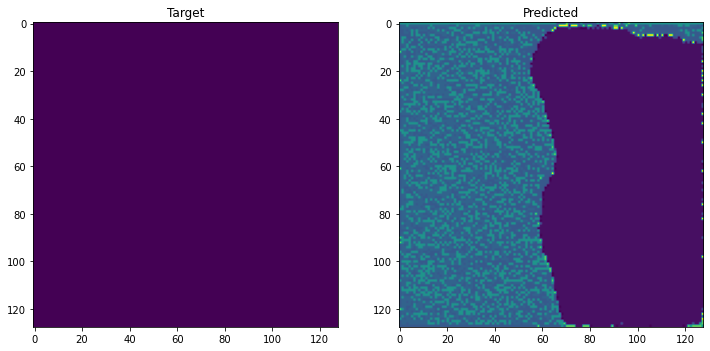

================================================== Training ==================================================
Epoch: 0, Train Loss: 180823.24602416123, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00


<ipython-input-4-48195ad04bef>:209: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])) is deprecated. Please ensure they have the same size.
  c_loss = F.binary_cross_entropy(torch.squeeze(C), c_label)


================================================= Validation =================================================
Epoch: 0, Val Loss: 62386.900342597335, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00
starting epoch: 1


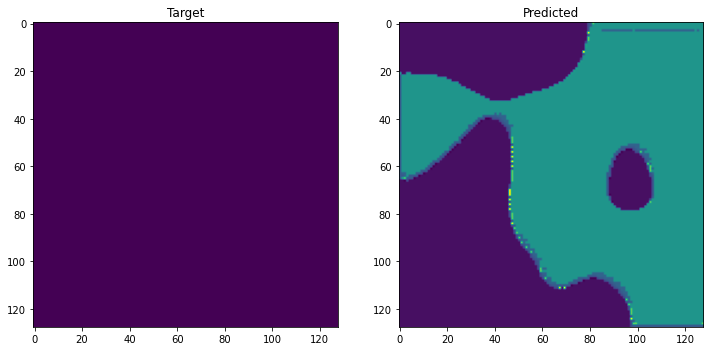

================================================== Training ==================================================
Epoch: 1, Train Loss: 110664.43890453348, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 1, Val Loss: 28092.091716828894, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00
starting epoch: 2


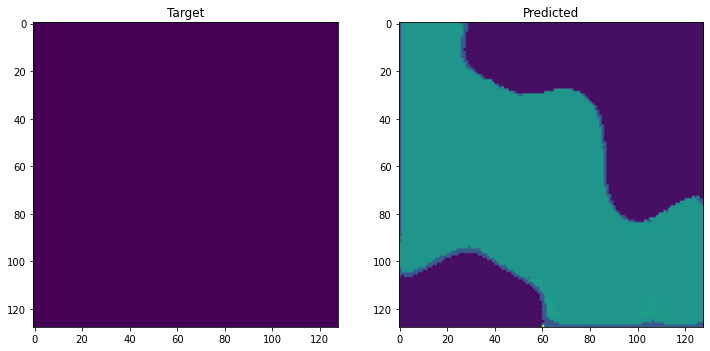

================================================== Training ==================================================
Epoch: 2, Train Loss: 59320.430009928, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 2, Val Loss: 19241.130751312758, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00
starting epoch: 3


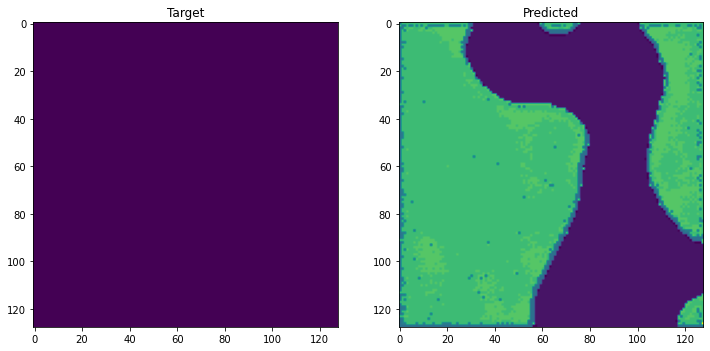

================================================== Training ==================================================
Epoch: 3, Train Loss: 31646.66467430133, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00
================================================= Validation =================================================
Epoch: 3, Val Loss: 10206.093355772926, Average Dice Score: 0.0
Dice Score Per Class
0: 0.00 1: 0.00 2: 0.00 3: 0.00 4: 0.00 5: 0.00 6: 0.00 7: 0.00 8: 0.00 9: 0.00 10: 0.00 11: 0.00 12: 0.00 13: 0.00 14: 0.00 15: 0.00 16: 0.00 17: 0.00 18: 0.00 19: 0.00 20: 0.00 21: 0.00 22: 0.00 23: 0.00 24: 0.00 25: 0.00
starting epoch: 4


In [ ]:
if __name__ == '__main__':
    main()